Clustering tree morphologies on the basis of topology via [Persistent Homology](https://en.wikipedia.org/wiki/Topological_data_analysis)

The distance metric is pairwise bottleneck distances between persistence diagrams generated from sub-level set filtrations over neuronal morphologies.

See [Li Y, Wang D, Ascoli GA, Mitra P, Wang Y (2017) Metrics for comparing neuronal tree shapes based on persistent homology. PLoS ONE](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0182184) 

for the general approach

In [1]:
import imagej
import time
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [2]:
# Initialize Fiji with GUI support.
ij = imagej.init(r'C:\Users\cam\Desktop\My_Desktop\Fiji.app', headless=False)
from jnius import autoclass, cast

In [3]:
Tree = autoclass('sc.fiji.snt.Tree')
MouseLightLoader = autoclass('sc.fiji.snt.io.MouseLightLoader')
PersistenceAnalyzer = autoclass('sc.fiji.snt.analysis.PersistenceAnalyzer')

In [4]:
diagram_map = {}  # global
tree_map = {}     # global
labels = []       # global

In [5]:
def filter_diagrams(diagrams, min_dist):
    # Remove components within some distance of the diagonal.
    # this corresponds to the length of a persistence interval.
    # Points very close to the diagonal may be considered noise.
    # This speeds up the process while largely retaining accuracy.
    for key, d in diagrams.items():
        inds = []
        for i in range(len(d)):
            if abs(d[i][0] - d[i][1]) < min_dist:
                inds.append(i)
        diagrams[key] = np.delete(d, inds, axis=0)
        
                     
def mydist(a1, a2):
    # bottleneck distance between two persistence diagrams
    return gd.bottleneck_distance(diagram_map[a1[0]], diagram_map[a2[0]])


def get_distance_matrix(cell_ids):
    M = pairwise_distances(cell_ids, metric=mydist)
    
    return M


# Hierarchical Clustering dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, orientation='right', labels=labels) 

    
def run():
    # Two types of mouse PT neuron from MOs with differing projection patterns descbried in 
    # Economo et al. Nature 2018
    # Group 0 contains the Medulla projecting sub-type. 
    # Group 1 contains the Thalamic projecting sub-type.
    # pre print at https://www.biorxiv.org/content/biorxiv/early/2017/12/05/229260.full.pdf
    group_0 = ['AA0011', 'AA0012', 'AA0115', 'AA0179', 'AA0180', 'AA0181', 'AA0182', 'AA0245', 
              'AA0250', 'AA0576', 'AA0726', 'AA0788', 'AA0791', 'AA0792']
    group_1 = ['AA0039', 'AA0101', 'AA0103', 'AA0105', 'AA0188', 'AA0278', 'AA0390', 'AA0394', 
              'AA0406', 'AA0577', 'AA0599', 'AA0633', 'AA0650', 'AA0781', 'AA0784', 'AA0799', 
              'AA0817', 'AA0837', 'AA0838', 'AA0844']
    
    groups = [group_0, group_1]
    
    cell_ids = []
    for num, group in enumerate(groups):
        for cell in group:
            loader = MouseLightLoader(cell)
            if not loader.isDatabaseAvailable(): 
                print("Database not available. Exiting...")
                return
            if not loader.idExists(): 
                print("Id not found in database. Exiting...")
                return 
            # Only compare axon topology
            tree = loader.getTree('axon')
            tree_map[tree.getLabel()[0:6]] = tree
            
            tree.setLabel(tree.getLabel().replace('.swc', '') + ' group: ' + str(num))
            labels.append(tree.getLabel())
            # Obtain Persistence Diagram as an nx2 array where each row corresponds
            # to one birth-death interval.
            diagram = np.asarray(ij.py.from_java(PersistenceAnalyzer(tree).getPersistenceDiagram()))
            
            key = int(tree.getLabel()[2:6])  # just the numeric part
            diagram_map[key] = diagram
            # necessary to pass a 2D numeric array to sklearn.metrics.pairwise_distances
            cell_ids.append([key]) 
        
    filter_diagrams(diagram_map, 500)
    
    t0 = time.time()
    matrix = get_distance_matrix(cell_ids)
    t1 = time.time()
    print(t1-t0, ' seconds to compute all distances')

    return matrix

In [6]:
matrix = run()

3.483062267303467  seconds to compute all distances


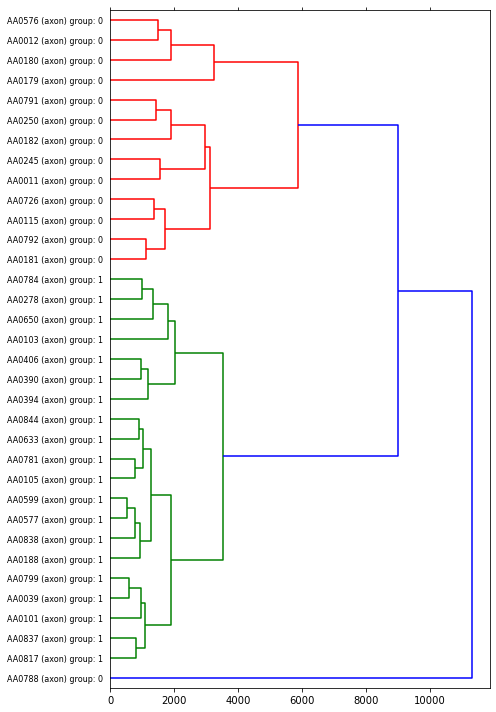

In [7]:
# Perform Agglomerative Clustering on the bottleneck distance matrix and plot a dendrogram
model = AgglomerativeClustering(affinity='precomputed', linkage='complete', distance_threshold=0, n_clusters=None)

# fit the model to the precomputed bottleneck distance matrix
model = model.fit(matrix)

fig, ax = plt.subplots(figsize=(7, 10)) # set size
plot_dendrogram(model)

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
# plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters